In [ ]:
import os
from glob import glob
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt
import gc

## Load in the Dataset

In [3]:
X = np.load("/content/drive/MyDrive/Project/Dataset/224x224/X_train.npy")

NameError: ignored

In [ ]:
y = np.load("/content/drive/MyDrive/Project/Dataset/224x224/y_train.npy")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33333, random_state=42)

In [ ]:
del X,y
gc.collect()

116

In [ ]:
X_train.shape, X_val.shape

((5007, 224, 224, 3), (2504, 224, 224, 3))

In [ ]:
y_train.shape, y_val.shape

((5007,), (2504,))

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
y_train.shape, y_val.shape

((5007, 7), (2504, 7))

In [ ]:
class_names = np.array(['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'])
print(class_names)

['akiec' 'bcc' 'bkl' 'df' 'nv' 'vasc' 'mel']


## Load the Pretrained Model

In [ ]:
pre_trained_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

In [ ]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1920)


## Define the Model

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Training

### Feature Extraction

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [ ]:
batch_size = 32
epochs = 3
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
156/156 [==============================] - 102s 498ms/step - loss: 1.5192 - accuracy: 0.6092 - val_loss: 0.9798 - val_accuracy: 0.6883
Epoch 2/3
156/156 [==============================] - 74s 474ms/step - loss: 0.9971 - accuracy: 0.6770 - val_loss: 0.9135 - val_accuracy: 0.6951
Epoch 3/3
156/156 [==============================] - 76s 484ms/step - loss: 0.9106 - accuracy: 0.6933 - val_loss: 0.8614 - val_accuracy: 0.7087


### Fine Tuning

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
batch_size = 32
epochs = 40
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/40
156/156 [==============================] - 136s 696ms/step - loss: 0.9063 - acc: 0.6844 - val_loss: 1.1451 - val_acc: 0.7067 - lr: 1.0000e-04
Epoch 2/40
156/156 [==============================] - 101s 643ms/step - loss: 0.6641 - acc: 0.7590 - val_loss: 0.7708 - val_acc: 0.7524 - lr: 1.0000e-04
Epoch 3/40
156/156 [==============================] - 108s 694ms/step - loss: 0.5719 - acc: 0.7970 - val_loss: 0.5898 - val_acc: 0.7917 - lr: 1.0000e-04
Epoch 4/40
156/156 [==============================] - 112s 714ms/step - loss: 0.4796 - acc: 0.8241 - val_loss: 0.5015 - val_acc: 0.8149 - lr: 1.0000e-04
Epoch 5/40
156/156 [==============================] - 104s 661ms/step - loss: 0.4328 - acc: 0.8440 - val_loss: 0.5025 - val_acc: 0.8317 - lr: 1.0000e-04
Epoch 6/40
156/156 [==============================] - 108s 693ms/step - loss: 0.3754 - acc: 0.8607 - val_loss: 0.4656 - val_acc: 0.8321 - lr: 1.0000e-04
Epoch 7/40
156/156 [==============================] - 101s 648ms/step - loss: 0.34

In [ ]:
model.save("/content/drive/MyDrive/Project/DenseNetFT111.h5")

In [ ]:
del X_train,y_train
gc.collect()

26

In [ ]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

79/79 [==============================] - 19s 180ms/step - loss: 0.6094 - acc: 0.8794
Validation: accuracy = 0.879393  ;  loss_v = 0.609350


In [ ]:
del X_val,y_val
gc.collect()

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
del loss_val, acc_val, acc, val_acc
gc.collect()

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_val)

NameError: ignored

In [ ]:
batch_size = 32
epochs = 10
history = model.fit(train_datagen.flow(X_val,y_val, batch_size=batch_size),
                              epochs = epochs,
                              verbose = 1, steps_per_epoch=(X_val.shape[0] // batch_size), 
                              )

In [ ]:
model.save("/content/drive/MyDrive/Project/DenseNetFT.h5")

# ***Testing***

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [ ]:
X_test = np.load("/content/drive/MyDrive/Project/Dataset/224x224/X_test.npy")

In [ ]:
y_test = np.load('/content/drive/MyDrive/Project/Dataset/224x224/y_test.npy')

In [ ]:
X_test.shape, y_test.shape

((2504, 224, 224, 3), (2504,))

In [ ]:
model = load_model('/content/drive/MyDrive/Project/DenseNetFT111.h5')

In [ ]:
gc.collect()

978

In [ ]:
y_test = to_categorical(y_test)

In [ ]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

79/79 [==============================] - 27s 170ms/step - loss: 0.7021 - acc: 0.8774
Test: accuracy = 0.877396  ;  loss = 0.702129


In [ ]:
del loss_test, acc_test
gc.collect()

727

In [ ]:
y_test = np.load('/content/drive/MyDrive/Project/Dataset/224x224/y_test.npy')

In [ ]:
pred_test=model.predict(X_test)
pred_test=np.argmax(pred_test, axis=-1)

**Confusion Matrix**

In [ ]:
test_confusion_matrix = confusion_matrix(y_test, pred_test)
test_confusion_matrix

array([[  48,    8,   12,    2,    1,    0,    5],
       [   3,  105,    8,    1,   10,    0,    3],
       [   7,    4,  208,    4,   18,    0,   12],
       [   1,    1,    1,   16,    0,    0,    4],
       [   3,    3,   56,    2, 1577,    0,   57],
       [   0,    1,    0,    0,    2,   36,    2],
       [   1,    0,   19,    0,   54,    2,  207]])

In [ ]:
test_sum=np.array([0, 0, 0, 0, 0,0,0])
for i in range(7):
    for j in range(7):
        test_sum[i]=test_sum[i]+test_confusion_matrix[i][j]
test_sum

array([  76,  130,  253,   23, 1698,   41,  283])

In [ ]:
test_confusion_matrix_percentage = test_confusion_matrix.astype(np.float32)

In [ ]:
for i in range(7):
    for j in range(7):
        test_confusion_matrix_percentage[i][j]=test_confusion_matrix_percentage[i][j]/test_sum[i]
test_confusion_matrix_percentage

array([[0.6315789 , 0.10526316, 0.15789473, 0.02631579, 0.01315789,
        0.        , 0.06578948],
       [0.02307692, 0.8076923 , 0.06153846, 0.00769231, 0.07692308,
        0.        , 0.02307692],
       [0.02766798, 0.01581028, 0.8221344 , 0.01581028, 0.07114624,
        0.        , 0.04743083],
       [0.04347826, 0.04347826, 0.04347826, 0.6956522 , 0.        ,
        0.        , 0.17391305],
       [0.00176678, 0.00176678, 0.03297998, 0.00117786, 0.92873967,
        0.        , 0.0335689 ],
       [0.        , 0.02439024, 0.        , 0.        , 0.04878049,
        0.8780488 , 0.04878049],
       [0.00353357, 0.        , 0.06713781, 0.        , 0.19081272,
        0.00706714, 0.73144877]], dtype=float32)

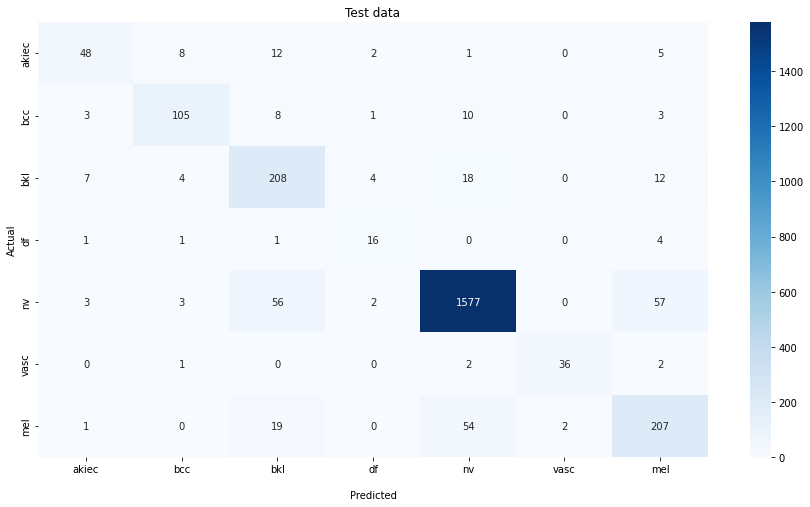

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
plt.figure(figsize = (15,8))
ax = sns.heatmap(test_confusion_matrix, annot=True, 
            fmt='d', cmap='Blues')

ax.set_title('Test data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['akiec','bcc', 'bkl','df', 'nv', 'vasc', 'mel'])
ax.yaxis.set_ticklabels(['akiec','bcc', 'bkl','df', 'nv', 'vasc', 'mel'])

## Display the visualization of the Confusion Matrix.
plt.show()
plt.savefig('/content/drive/MyDrive/Project/den')

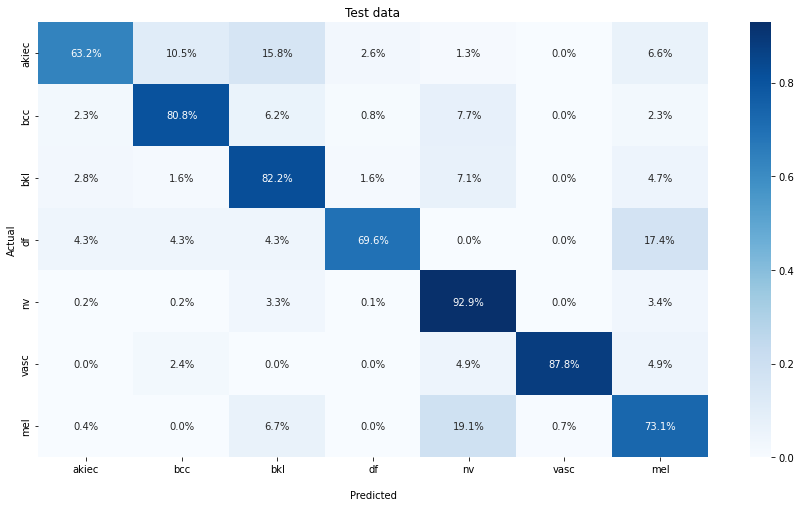

In [ ]:
import seaborn as sns
plt.figure(figsize = (15,8))
ax = sns.heatmap(test_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Test data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['akiec','bcc', 'bkl','df', 'nv', 'vasc', 'mel'])
ax.yaxis.set_ticklabels(['akiec','bcc', 'bkl','df', 'nv', 'vasc', 'mel'])

## Display the visualization of the Confusion Matrix.
plt.show()

**F1 Score**

In [ ]:
report = classification_report(y_test, pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.63      0.69        76
           1       0.86      0.81      0.83       130
           2       0.68      0.82      0.75       253
           3       0.64      0.70      0.67        23
           4       0.95      0.93      0.94      1698
           5       0.95      0.88      0.91        41
           6       0.71      0.73      0.72       283

    accuracy                           0.88      2504
   macro avg       0.79      0.79      0.79      2504
weighted avg       0.88      0.88      0.88      2504

